# Exploratory Data Analysis (EDA)
## Credit Risk Model - Xente Transaction Data

**Objective:** Explore the eCommerce transaction dataset to uncover patterns, identify data quality issues, and form hypotheses for feature engineering.

**Dataset:** Kaggle Xente Challenge - Transaction data for buy-now-pay-later credit scoring

**Key Questions to Answer:**
1. What is the structure and quality of our data?
2. What patterns exist in customer transaction behavior?
3. Are there data quality issues (missing values, outliers)?
4. What features show strong relationships?
5. What temporal patterns exist in transactions?

This analysis will inform our feature engineering strategy and RFM-based proxy target creation.

## 1. Setup and Imports

In [35]:
# Standard libraries
import pandas as pd
import numpy as np
import warnings
from pathlib import Path

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy import stats
from scipy.stats import skew, kurtosis

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Suppress warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Load and Inspect Data Structure

**Goal:** Load the raw transaction data and understand its basic structure, dimensions, and data types.

We'll examine:
- Dataset dimensions (rows and columns)
- First few rows to understand the data format
- Data types for each column
- Presence of duplicate rows or transactions

In [36]:
# Load the raw transaction data
data_path = Path('../data/raw/data.csv')

if not data_path.exists():
    raise FileNotFoundError(f"Data file not found at {data_path}")

df = pd.read_csv(data_path)

print(f"✓ Data loaded successfully")
print(f"\nDataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

✓ Data loaded successfully

Dataset Shape: 95,662 rows × 16 columns


In [37]:
# Display first few rows
print("\n=== First 5 Rows ===")
df.head()


=== First 5 Rows ===


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.000,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.000,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.000,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.000,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.000,644,2018-11-15T03:34:21Z,2,0


In [5]:
# Data types and non-null counts
print("\n=== Data Types and Non-Null Counts ===")
df.info()


=== Data Types and Non-Null Counts ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 no

In [38]:
# Column names
print("\n=== Column Names ===")
for col in df.columns.tolist():
  print(col)


=== Column Names ===
TransactionId
BatchId
AccountId
SubscriptionId
CustomerId
CurrencyCode
CountryCode
ProviderId
ProductId
ProductCategory
ChannelId
Amount
Value
TransactionStartTime
PricingStrategy
FraudResult


In [9]:
# Check for duplicate rows
n_duplicates = df.duplicated().sum()
print(f"\n=== Duplicate Rows ===")
print(f"Number of duplicate rows: {n_duplicates:,} ({n_duplicates/len(df)*100:.2f}%)")

# Check for duplicate TransactionIds
if 'TransactionId' in df.columns:
    n_dup_transactions = df['TransactionId'].duplicated().sum()
    print(f"Duplicate TransactionIds: {n_dup_transactions:,}")


=== Duplicate Rows ===
Number of duplicate rows: 0 (0.00%)
Duplicate TransactionIds: 0


## 3. Summary Statistics Analysis

**Goal:** Calculate and interpret descriptive statistics to understand the central tendency, spread, and shape of our numerical features.

Key metrics to examine:
- **Central Tendency:** Mean, Median (identify if distributions are symmetric)
- **Dispersion:** Standard Deviation, Coefficient of Variation (measure spread)
- **Shape:** Skewness (symmetry), Kurtosis (tail heaviness)

Understanding these statistics helps us decide on appropriate transformations and scaling strategies for modeling.

In [39]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\n=== Column Types ===")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")


=== Column Types ===
Numerical columns (5): ['CountryCode', 'Amount', 'Value', 'PricingStrategy', 'FraudResult']

Categorical columns (11): ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'TransactionStartTime']


In [40]:
# Summary statistics for numerical features
print("\n=== Numerical Features: Summary Statistics ===")
df[numerical_cols].describe().T


=== Numerical Features: Summary Statistics ===


,count,mean,std,min,25%,50%,75%,max
CountryCode,95662.000,256.000,0.000,256.000,256.000,256.000,256.000,256.000
Amount,95662.000,6717.846,123306.797,-1000000.000,-50.000,1000.000,2800.000,9880000.000
Value,95662.000,9900.584,123122.088,2.000,275.000,1000.000,5000.000,9880000.000
PricingStrategy,95662.000,2.256,0.733,0.000,2.000,2.000,2.000,4.000
FraudResult,95662.000,0.002,0.045,0.000,0.000,0.000,0.000,1.000


In [41]:
# Additional statistics: skewness and kurtosis
print("\n=== Distribution Shape: Skewness and Kurtosis ===")

stats_df = pd.DataFrame({
    'Mean': df[numerical_cols].mean(),
    'Median': df[numerical_cols].median(),
    'Std': df[numerical_cols].std(),
    'Skewness': df[numerical_cols].apply(lambda x: skew(x.dropna())),
    'Kurtosis': df[numerical_cols].apply(lambda x: kurtosis(x.dropna())),
    'CV': df[numerical_cols].std() / df[numerical_cols].mean()  # Coefficient of variation
})

stats_df


=== Distribution Shape: Skewness and Kurtosis ===


,Mean,Median,Std,Skewness,Kurtosis,CV
CountryCode,256.000,256.000,0.000,NaN,NaN,0.000
Amount,6717.846,1000.000,123306.797,51.098,3362.952,18.355
Value,9900.584,1000.000,123122.088,51.290,3377.893,12.436
PricingStrategy,2.256,2.000,0.733,1.659,2.087,0.325
FraudResult,0.002,0.000,0.045,22.196,490.660,22.241


In [42]:
# Interpretation of skewness
print("\n=== Skewness Interpretation ===")
for col in numerical_cols:
    skew_val = skew(df[col].dropna())
    if abs(skew_val) < 0.5:
        interp = "fairly symmetric"
    elif skew_val > 0:
        interp = "right-skewed (positive skew)"
    else:
        interp = "left-skewed (negative skew)"
    print(f"{col}: {skew_val:.3f} - {interp}")


=== Skewness Interpretation ===
CountryCode: nan - left-skewed (negative skew)
Amount: 51.098 - right-skewed (positive skew)
Value: 51.290 - right-skewed (positive skew)
PricingStrategy: 1.659 - right-skewed (positive skew)
FraudResult: 22.196 - right-skewed (positive skew)


## 4. Numerical Feature Distributions

**Goal:** Visualize the distribution of numerical features to identify patterns, skewness, and outliers.

**Why This Matters:**
- **Right-skewed distributions** (long right tail) may benefit from log transformation
- **Bimodal distributions** could indicate distinct customer segments
- **Heavy-tailed distributions** suggest presence of outliers
- Understanding distributions informs feature engineering and scaling choices

We'll create histograms with KDE overlays to see both the overall shape and smoothed probability density.


=== Numerical Feature Distributions ===


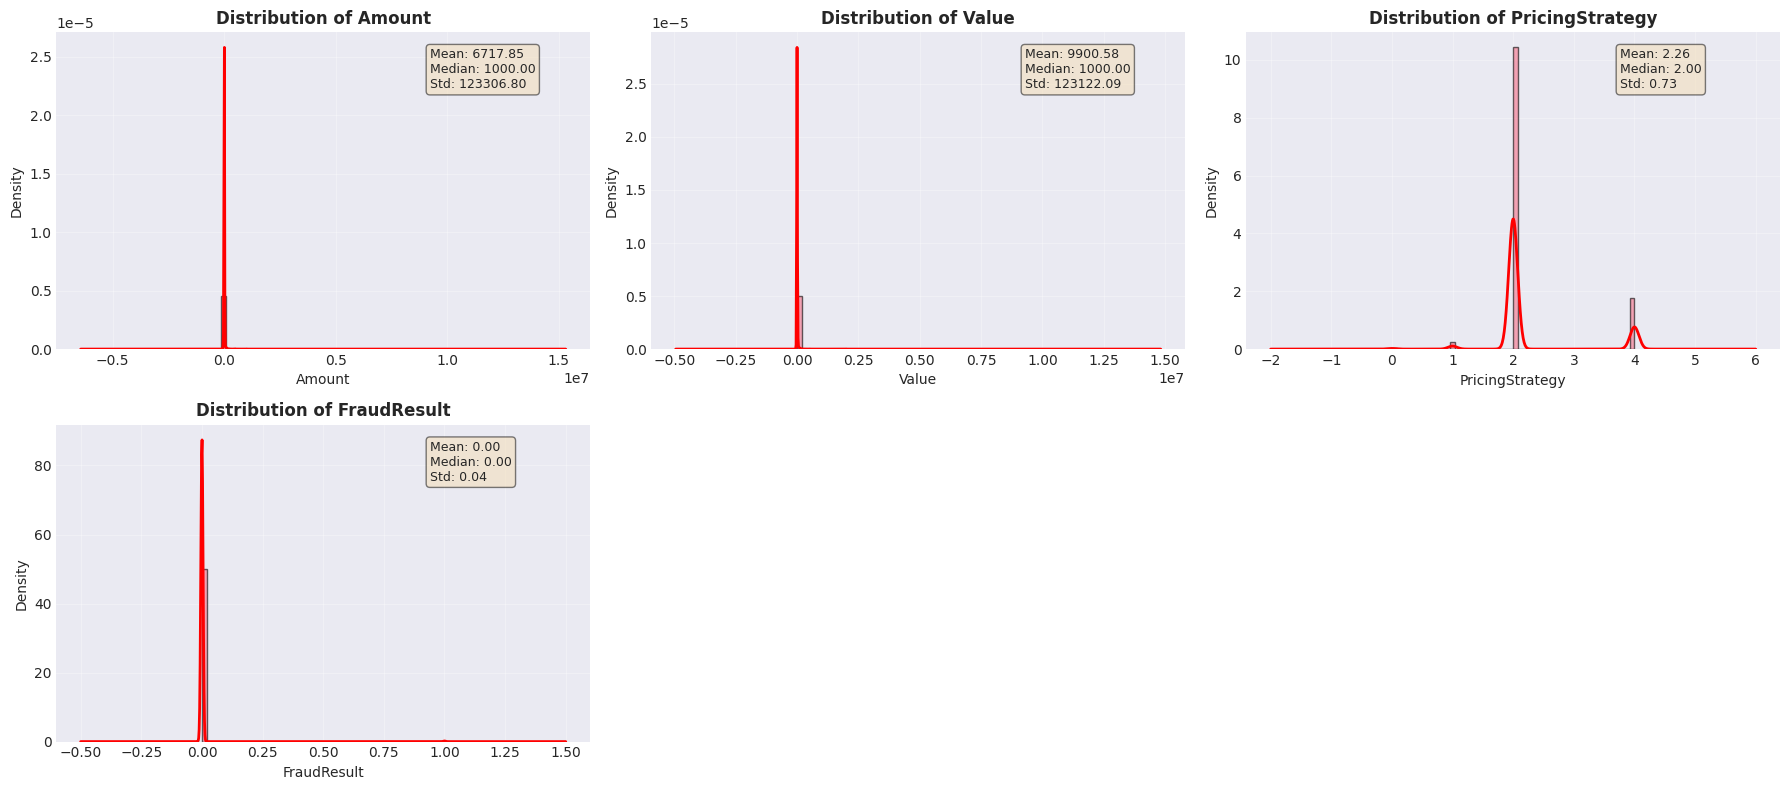

In [47]:
# Histograms and KDE plots for numerical features
print("\n=== Numerical Feature Distributions ===")

# Filter out zero-variance columns (constant values) for KDE
numerical_cols_with_variance = [col for col in numerical_cols if df[col].std() > 0]
n_cols = len(numerical_cols_with_variance)
n_rows = (n_cols + 2) // 3

fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 4))
axes = axes.flatten() if n_cols > 1 else [axes]

for idx, col in enumerate(numerical_cols_with_variance):
    ax = axes[idx]
    
    # Plot histogram with KDE
    df[col].hist(bins=50, ax=ax, alpha=0.6, edgecolor='black', density=True)
    df[col].plot(kind='kde', ax=ax, color='red', linewidth=2)
    
    ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    
    # Add statistics text box
    stats_text = f"Mean: {df[col].mean():.2f}\nMedian: {df[col].median():.2f}\nStd: {df[col].std():.2f}"
    ax.text(0.7, 0.95, stats_text, transform=ax.transAxes, 
            fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Remove empty subplots
for idx in range(n_cols, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


=== Deep Dive: Amount and Value ===


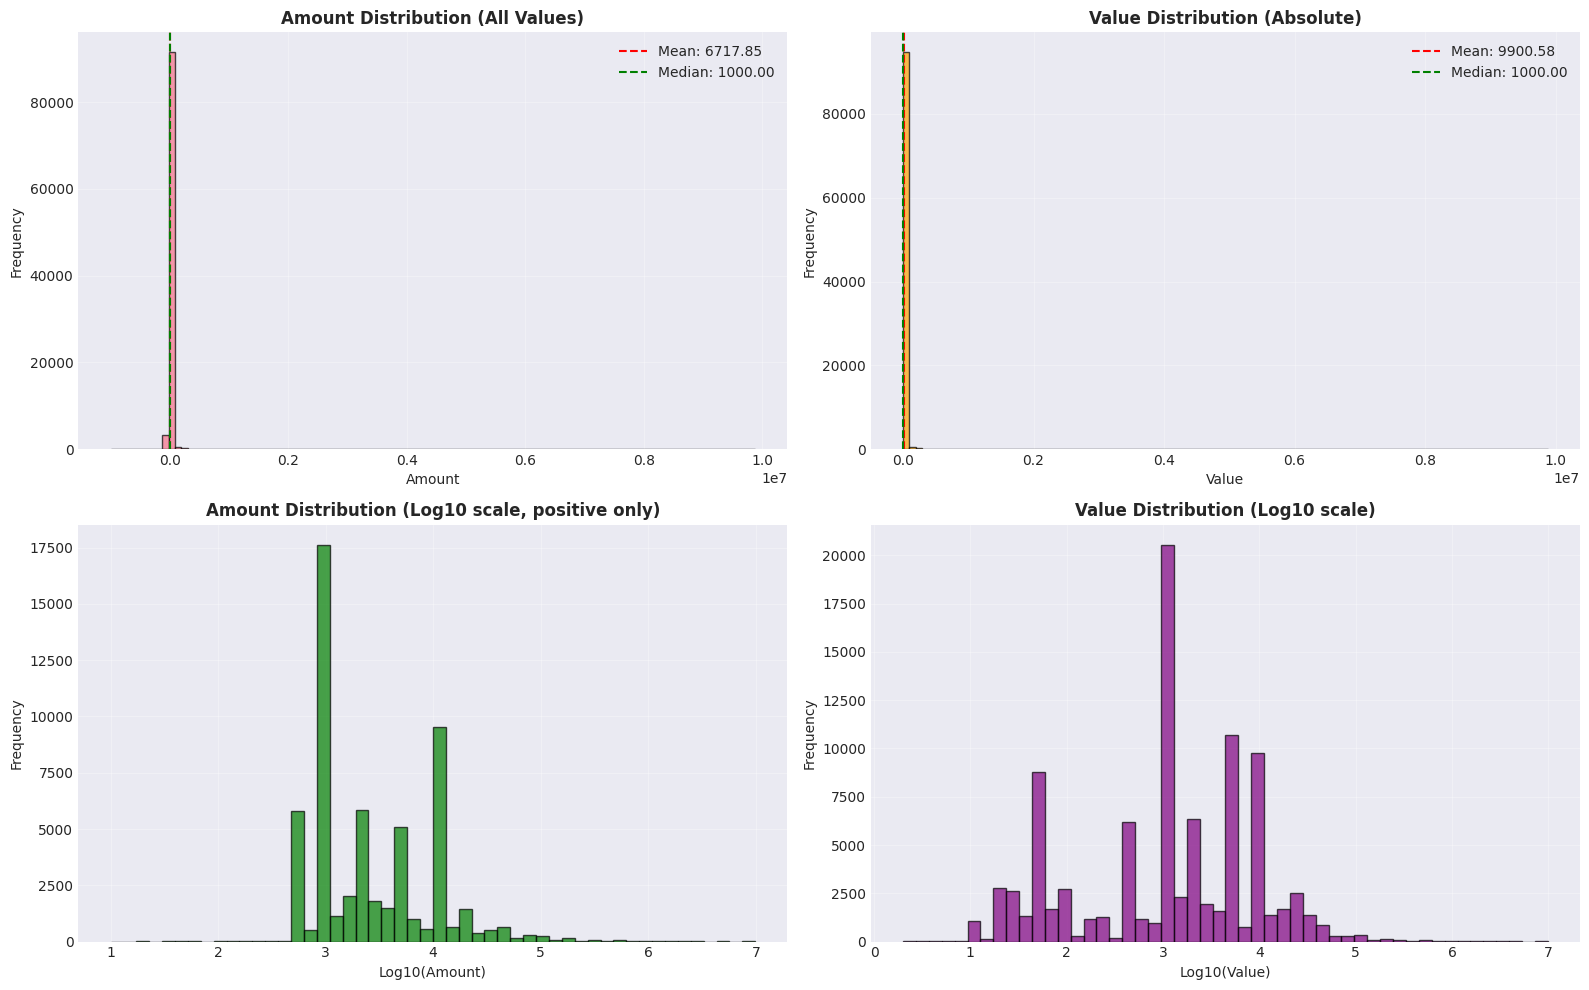


Amount Sign Distribution:
  Positive (debits): 57,473 (60.08%)
  Negative (credits): 38,189 (39.92%)
  Zero: 0 (0.00%)


In [16]:
# Focus on Amount and Value (key features)
if 'Amount' in df.columns and 'Value' in df.columns:
    print("\n=== Deep Dive: Amount and Value ===")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Amount distribution
    axes[0, 0].hist(df['Amount'], bins=100, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Amount Distribution (All Values)', fontweight='bold')
    axes[0, 0].set_xlabel('Amount')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(df['Amount'].mean(), color='red', linestyle='--', label=f'Mean: {df["Amount"].mean():.2f}')
    axes[0, 0].axvline(df['Amount'].median(), color='green', linestyle='--', label=f'Median: {df["Amount"].median():.2f}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Value distribution
    axes[0, 1].hist(df['Value'], bins=100, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].set_title('Value Distribution (Absolute)', fontweight='bold')
    axes[0, 1].set_xlabel('Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(df['Value'].mean(), color='red', linestyle='--', label=f'Mean: {df["Value"].mean():.2f}')
    axes[0, 1].axvline(df['Value'].median(), color='green', linestyle='--', label=f'Median: {df["Value"].median():.2f}')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Amount log scale (if positive values exist)
    positive_amount = df[df['Amount'] > 0]['Amount']
    if len(positive_amount) > 0:
        axes[1, 0].hist(np.log10(positive_amount), bins=50, edgecolor='black', alpha=0.7, color='green')
        axes[1, 0].set_title('Amount Distribution (Log10 scale, positive only)', fontweight='bold')
        axes[1, 0].set_xlabel('Log10(Amount)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Value log scale
    positive_value = df[df['Value'] > 0]['Value']
    if len(positive_value) > 0:
        axes[1, 1].hist(np.log10(positive_value), bins=50, edgecolor='black', alpha=0.7, color='purple')
        axes[1, 1].set_title('Value Distribution (Log10 scale)', fontweight='bold')
        axes[1, 1].set_xlabel('Log10(Value)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Check for negative amounts (credits)
    n_negative = (df['Amount'] < 0).sum()
    n_positive = (df['Amount'] > 0).sum()
    n_zero = (df['Amount'] == 0).sum()
    
    print(f"\nAmount Sign Distribution:")
    print(f"  Positive (debits): {n_positive:,} ({n_positive/len(df)*100:.2f}%)")
    print(f"  Negative (credits): {n_negative:,} ({n_negative/len(df)*100:.2f}%)")
    print(f"  Zero: {n_zero:,} ({n_zero/len(df)*100:.2f}%)")

### Deep Dive: Amount and Value Features

The **Amount** and **Value** features deserve special attention as they represent transaction magnitude - the core financial metric for credit risk assessment. Let's examine their distributions in detail, including both linear and logarithmic scales to better understand the full range of transaction values.

## 5. Categorical Feature Distributions

**Goal:** Analyze categorical features to understand cardinality, frequency distributions, and potential encoding strategies.

**Cardinality Classification:**
- **Low (<10 unique values):** Use One-Hot Encoding
- **Medium (10-50 unique values):** Consider Target/Label Encoding or One-Hot
- **High (50+ unique values):** Use Label/Target Encoding or Embeddings

Understanding categorical distributions helps us:
- Identify dominant categories that might introduce bias
- Detect rare categories that may need special handling
- Choose appropriate encoding strategies for modeling

In [44]:
# Summary of categorical features
print("\n=== Categorical Features: Cardinality ===")

cat_summary = pd.DataFrame({
    'Unique_Values': df[categorical_cols].nunique(),
    'Missing_Count': df[categorical_cols].isnull().sum(),
    'Missing_Percent': (df[categorical_cols].isnull().sum() / len(df) * 100).round(2)
})

cat_summary['Cardinality_Type'] = cat_summary['Unique_Values'].apply(
    lambda x: 'Low (<10)' if x < 10 else 'Medium (10-50)' if x < 50 else 'High (50+)'
)

cat_summary


=== Categorical Features: Cardinality ===


,Unique_Values,Missing_Count,Missing_Percent,Cardinality_Type
TransactionId,95662,0,0.000,High (50+)
BatchId,94809,0,0.000,High (50+)
AccountId,3633,0,0.000,High (50+)
SubscriptionId,3627,0,0.000,High (50+)
CustomerId,3742,0,0.000,High (50+)
CurrencyCode,1,0,0.000,Low (<10)
ProviderId,6,0,0.000,Low (<10)
ProductId,23,0,0.000,Medium (10-50)
ProductCategory,9,0,0.000,Low (<10)
ChannelId,4,0,0.000,Low (<10)


In [18]:
# Frequency analysis for key categorical features
key_categorical = ['ProductCategory', 'ChannelId', 'ProviderId', 'CurrencyCode', 'PricingStrategy']
available_cat = [col for col in key_categorical if col in df.columns]

for col in available_cat:
    print(f"\n=== {col} - Top 10 Values ===")
    value_counts = df[col].value_counts().head(10)
    value_pct = (value_counts / len(df) * 100).round(2)
    
    result_df = pd.DataFrame({
        'Count': value_counts,
        'Percentage': value_pct
    })
    print(result_df)


=== ProductCategory - Top 10 Values ===
                    Count  Percentage
ProductCategory                      
financial_services  45405      47.460
airtime             45027      47.070
utility_bill         1920       2.010
data_bundles         1613       1.690
tv                   1279       1.340
ticket                216       0.230
movies                175       0.180
transport              25       0.030
other                   2       0.000

=== ChannelId - Top 10 Values ===
             Count  Percentage
ChannelId                     
ChannelId_3  56935      59.520
ChannelId_2  37141      38.830
ChannelId_5   1048       1.100
ChannelId_1    538       0.560

=== ProviderId - Top 10 Values ===
              Count  Percentage
ProviderId                     
ProviderId_4  38189      39.920
ProviderId_6  34186      35.740
ProviderId_5  14542      15.200
ProviderId_1   5643       5.900
ProviderId_3   3084       3.220
ProviderId_2     18       0.020

=== CurrencyCode - Top 10 V

### Frequency Analysis of Key Categorical Features

Let's examine the top values for each categorical feature to understand:
- **Dominance:** Are there categories that appear much more frequently than others?
- **Balance:** Is there a relatively even distribution or high concentration?
- **Rare categories:** Do we have many infrequent categories that may need special handling?


=== Categorical Feature Distributions (Bar Charts) ===


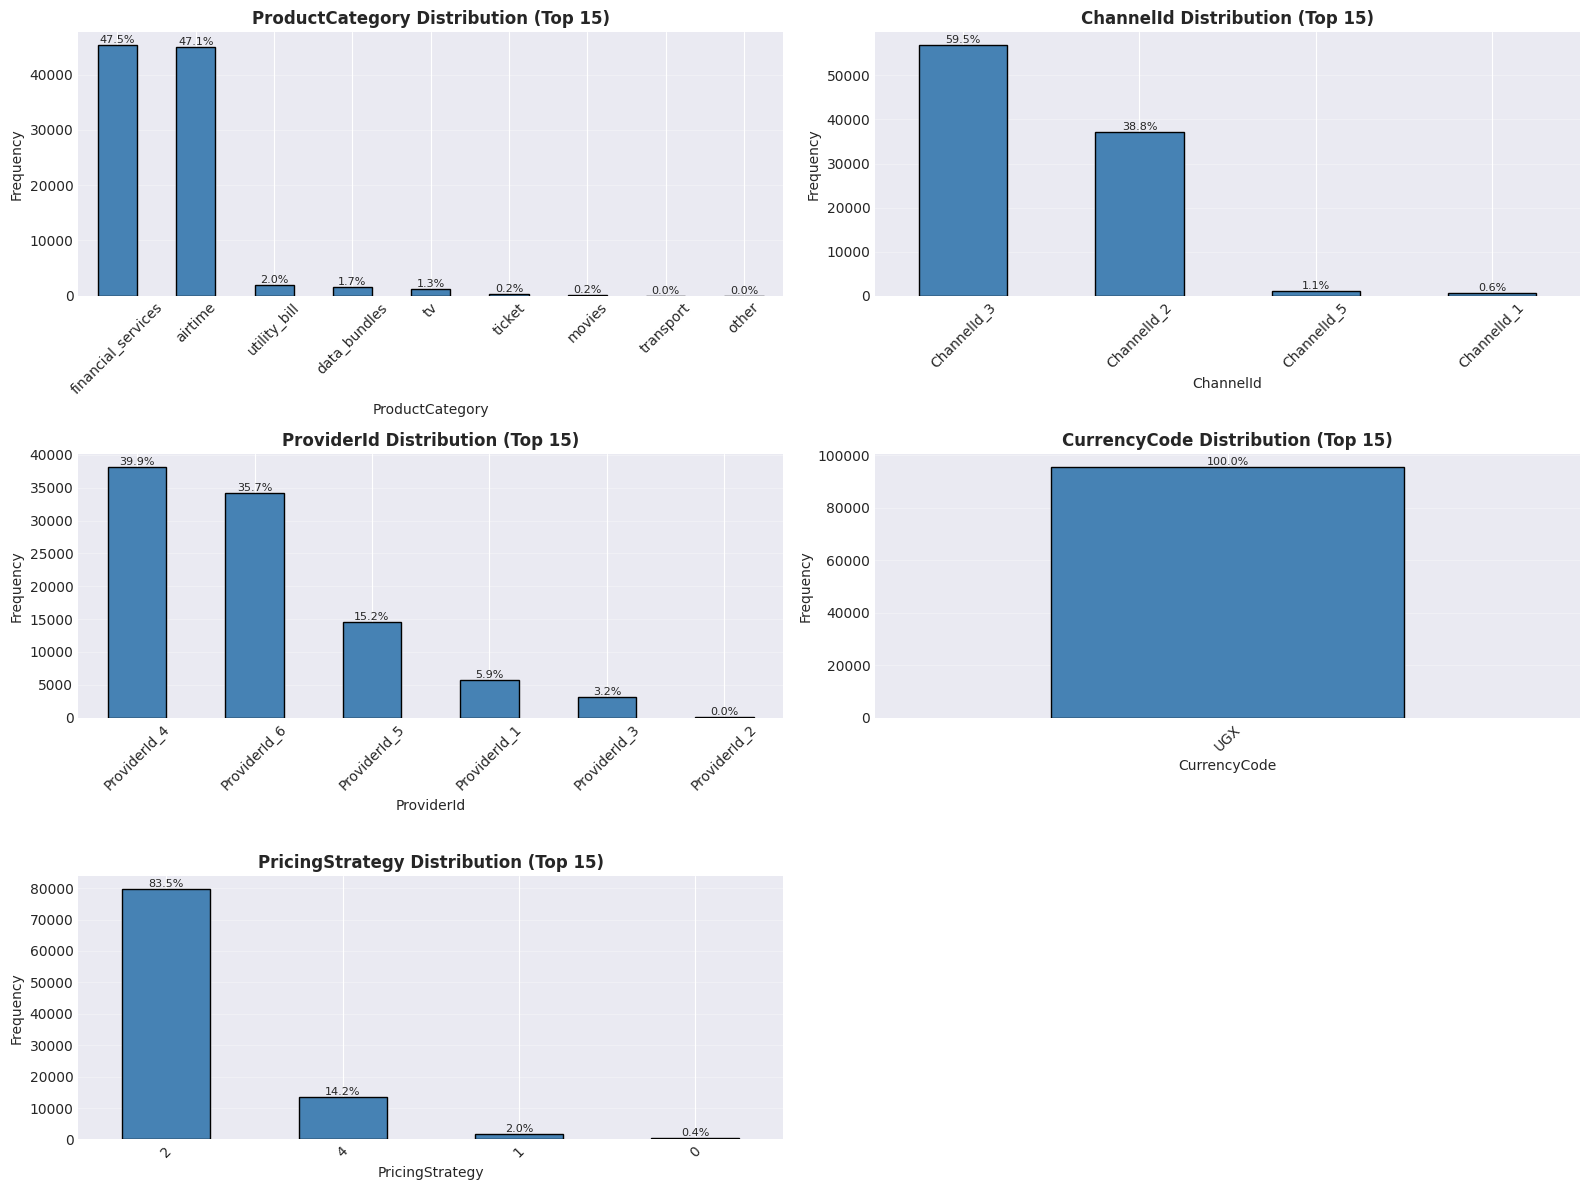

In [19]:
# Visualize categorical distributions
print("\n=== Categorical Feature Distributions (Bar Charts) ===")

# Select low to medium cardinality features for visualization
viz_cols = [col for col in available_cat if df[col].nunique() < 20]

if viz_cols:
    n_cols_viz = len(viz_cols)
    n_rows_viz = (n_cols_viz + 1) // 2
    
    fig, axes = plt.subplots(n_rows_viz, 2, figsize=(16, n_rows_viz * 4))
    axes = axes.flatten() if n_cols_viz > 1 else [axes]
    
    for idx, col in enumerate(viz_cols):
        ax = axes[idx]
        
        value_counts = df[col].value_counts().head(15)
        value_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
        
        ax.set_title(f'{col} Distribution (Top 15)', fontsize=12, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add percentage labels on bars
        for i, v in enumerate(value_counts):
            ax.text(i, v, f'{v/len(df)*100:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # Remove empty subplots
    for idx in range(n_cols_viz, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
else:
    print("No low-cardinality categorical features to visualize.")

In [20]:
# High cardinality features analysis
high_card_cols = [col for col in categorical_cols if df[col].nunique() >= 50]

if high_card_cols:
    print("\n=== High Cardinality Features Analysis ===")
    for col in high_card_cols:
        n_unique = df[col].nunique()
        top_value_pct = (df[col].value_counts().iloc[0] / len(df) * 100)
        print(f"\n{col}:")
        print(f"  Unique values: {n_unique:,}")
        print(f"  Top value frequency: {top_value_pct:.2f}%")
        print(f"  Recommendation: Use Label/Target Encoding or Embedding")


=== High Cardinality Features Analysis ===

TransactionId:
  Unique values: 95,662
  Top value frequency: 0.00%
  Recommendation: Use Label/Target Encoding or Embedding

BatchId:
  Unique values: 94,809
  Top value frequency: 0.03%
  Recommendation: Use Label/Target Encoding or Embedding

AccountId:
  Unique values: 3,633
  Top value frequency: 32.29%
  Recommendation: Use Label/Target Encoding or Embedding

SubscriptionId:
  Unique values: 3,627
  Top value frequency: 34.11%
  Recommendation: Use Label/Target Encoding or Embedding

CustomerId:
  Unique values: 3,742
  Top value frequency: 4.28%
  Recommendation: Use Label/Target Encoding or Embedding

TransactionStartTime:
  Unique values: 94,556
  Top value frequency: 0.02%
  Recommendation: Use Label/Target Encoding or Embedding


## 6. Correlation Analysis

**Goal:** Identify relationships between numerical features to understand multicollinearity and potential feature interactions.

**Why This Matters for Credit Risk Modeling:**
- **High correlation (|r| > 0.7)** indicates redundant features - we may need to drop one
- **Moderate correlation (0.3 < |r| < 0.7)** suggests meaningful relationships for feature engineering
- **Low correlation** indicates independent information sources

Correlation analysis helps us:
- Avoid multicollinearity issues in linear models
- Identify feature pairs for interaction terms
- Understand which features provide unique information

In [45]:
# Correlation matrix for numerical features
print("\n=== Correlation Matrix ===")

correlation_matrix = df[numerical_cols].corr()

# Display correlation matrix
correlation_matrix


=== Correlation Matrix ===


,CountryCode,Amount,Value,PricingStrategy,FraudResult
CountryCode,NaN,NaN,NaN,NaN,NaN
Amount,NaN,1.000,0.990,-0.062,0.557
Value,NaN,0.990,1.000,-0.017,0.567
PricingStrategy,NaN,-0.062,-0.017,1.000,-0.034
FraudResult,NaN,0.557,0.567,-0.034,1.000


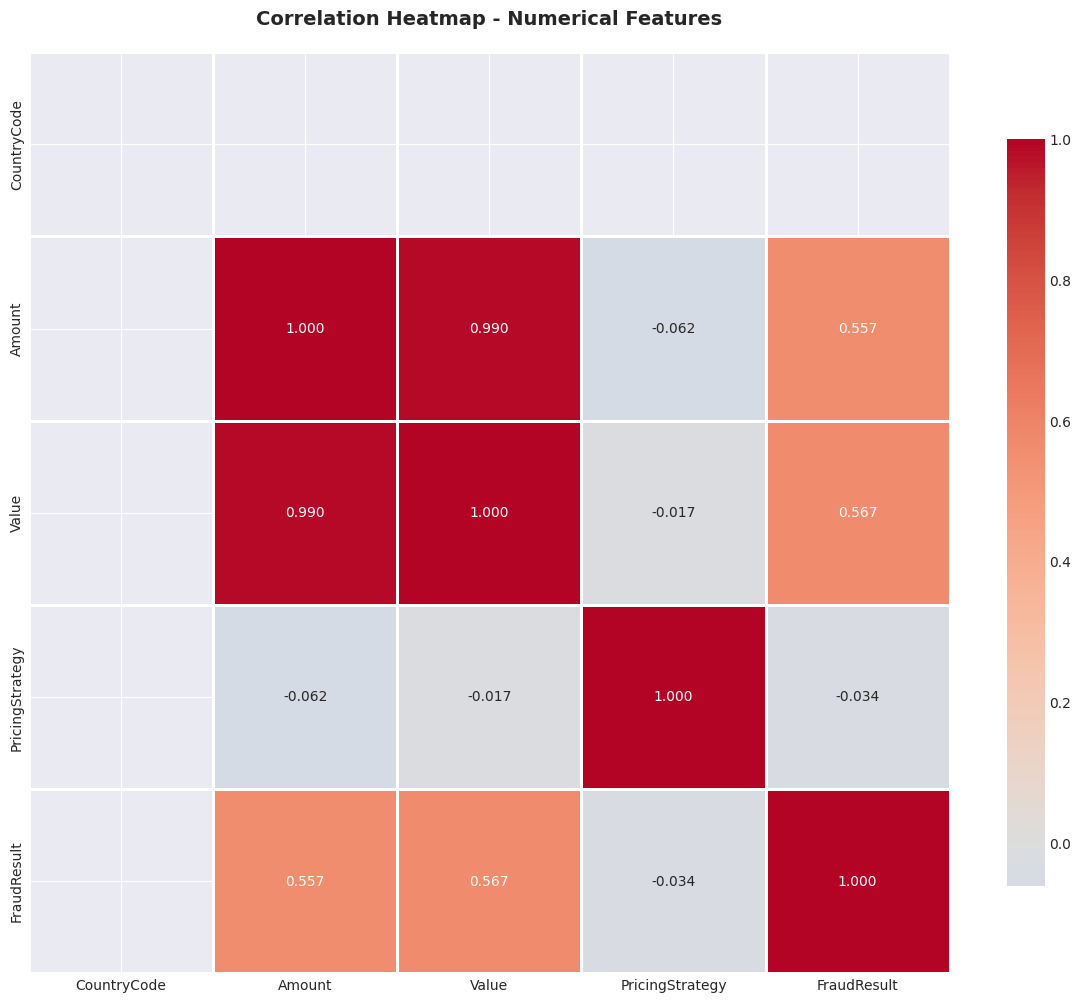

In [48]:
# Visualize correlation heatmap
plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.3f', 
            cmap='coolwarm', 
            center=0,
            square=True, 
            linewidths=1,
            cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap - Numerical Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [46]:
# Identify highly correlated features
print("\n=== Highly Correlated Feature Pairs ===")

# Get upper triangle of correlation matrix
upper_triangle = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
corr_pairs = correlation_matrix.where(upper_triangle).stack().sort_values(ascending=False)

# Filter for high correlations (|r| > 0.7)
high_corr = corr_pairs[abs(corr_pairs) > 0.7]

if len(high_corr) > 0:
    print(f"Found {len(high_corr)} feature pairs with |correlation| > 0.7:\n")
    for (feat1, feat2), corr_val in high_corr.items():
        print(f"{feat1} <-> {feat2}: {corr_val:.3f}")
else:
    print("No feature pairs with |correlation| > 0.7 found.")
    # Show top 5 correlations anyway
    print("\nTop 5 correlations:")
    print(corr_pairs.head())


=== Highly Correlated Feature Pairs ===
Found 1 feature pairs with |correlation| > 0.7:

Amount <-> Value: 0.990


## 7. Missing Values Analysis

**Goal:** Identify and quantify missing data, then propose appropriate imputation strategies.

**Missing Data Strategies:**
- **< 5% missing:** Simple imputation (median for numerical, mode for categorical)
- **5-50% missing:** Imputation + create missing indicator feature (missingness may be informative)
- **> 50% missing:** Consider dropping the column (too little information)

**Why This Matters:**
- Missing values can introduce bias if not handled properly
- In credit risk, missingness itself might be a signal (e.g., missing income data)
- Basel II requires documentation of how missing data is handled

In [43]:
# Missing values summary
print("\n=== Missing Values Analysis ===")

missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percent': (df.isnull().sum() / len(df) * 100).round(2),
    'Data_Type': df.dtypes
})

# Sort by missing percentage
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)

if len(missing_df) > 0:
    print(f"\nColumns with missing values: {len(missing_df)}\n")
    print(missing_df.to_string(index=False))
else:
    print("\n✓ No missing values found in the dataset!")


=== Missing Values Analysis ===

✓ No missing values found in the dataset!


In [30]:
# Proposed imputation strategies
print("\n=== Proposed Imputation Strategies ===")

if len(missing_df) > 0:
    for _, row in missing_df.iterrows():
        col = row['Column']
        pct = row['Missing_Percent']
        dtype = row['Data_Type']
        
        print(f"\n{col} ({pct:.2f}% missing):")
        
        if pct > 50:
            print("  → Strategy: DROP column (too many missing values)")
        elif pct > 10:
            if dtype in ['int64', 'float64']:
                print("  → Strategy: MEDIAN imputation + create missing indicator feature")
            else:
                print("  → Strategy: MODE imputation + create missing indicator feature")
        else:
            if dtype in ['int64', 'float64']:
                print("  → Strategy: MEDIAN imputation (small percentage)")
            else:
                print("  → Strategy: MODE imputation or 'UNKNOWN' category")
else:
    print("\n✓ No imputation needed - dataset is complete!")


=== Proposed Imputation Strategies ===

✓ No imputation needed - dataset is complete!


### Missing Data Visualization

If we had missing values, we would visualize them here to understand patterns. A good practice is to check if missingness is random or systematic (e.g., always missing for certain customer segments).

## 8. Outlier Detection

**Goal:** Identify outliers using box plots and the IQR (Interquartile Range) method, then propose handling strategies.

**IQR Method:**
- **Lower Bound:** Q1 - 1.5 × IQR
- **Upper Bound:** Q3 + 1.5 × IQR
- Points outside these bounds are considered outliers

**Outlier Handling Strategies:**
- **> 10% outliers:** Log transformation or Winsorization (capping at percentiles)
- **5-10% outliers:** Winsorization at 95th/99th percentile
- **1-5% outliers:** Keep but use robust scaling
- **< 1% outliers:** Keep as-is

**Critical Consideration:** In credit risk, outliers may represent legitimate extreme behaviors (very high spenders, unusual transaction patterns) that are predictive of risk. We must balance statistical cleanliness with business reality.


=== Outlier Detection: Box Plots ===


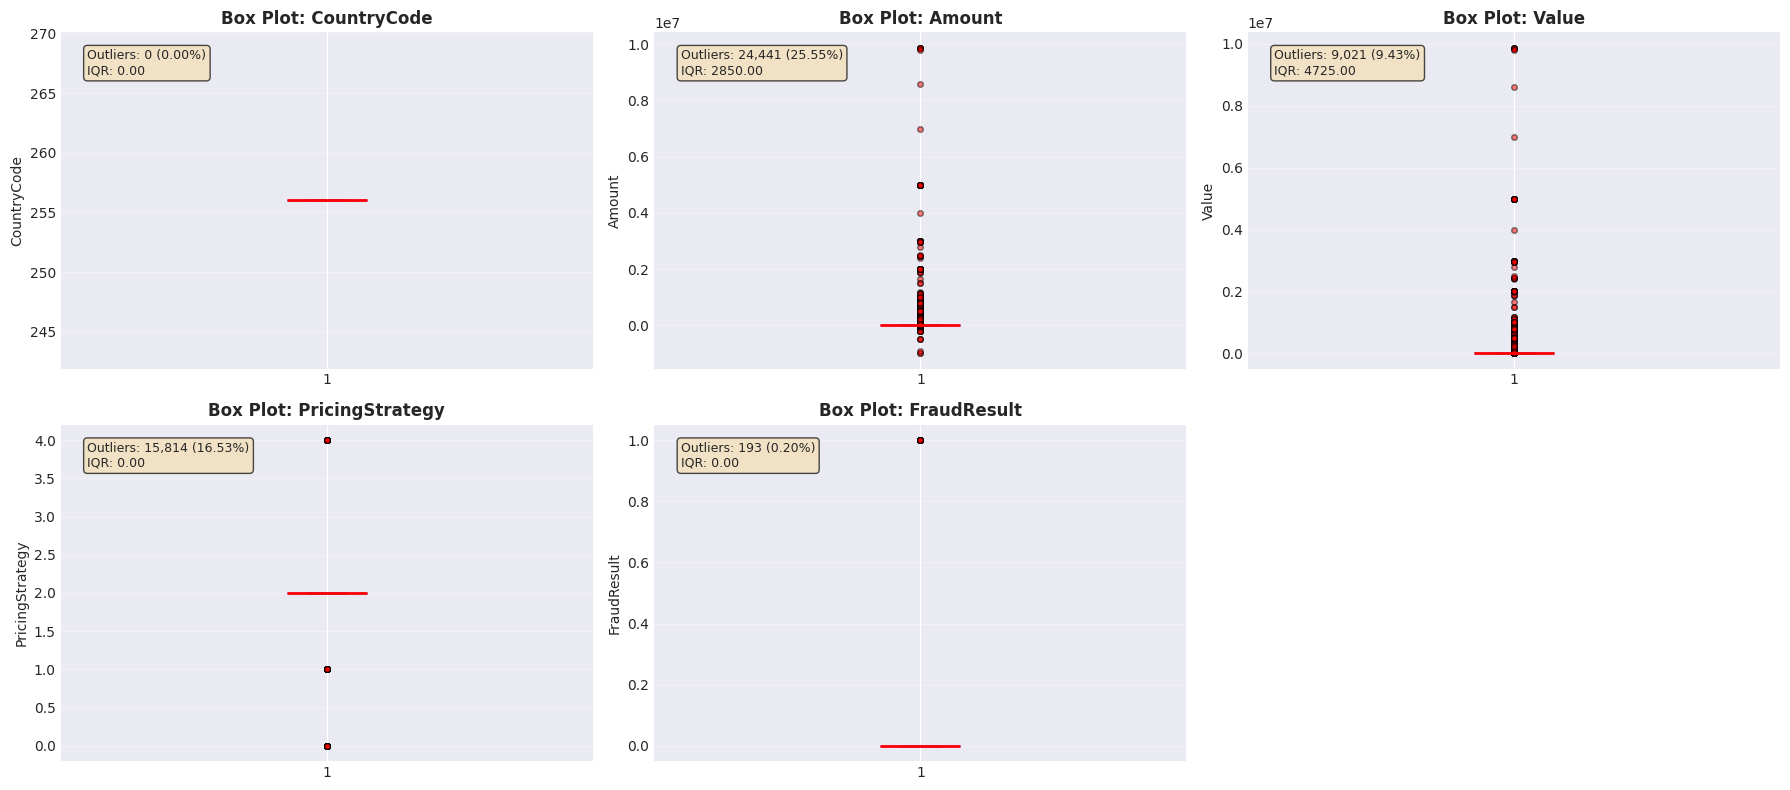

In [31]:
# Box plots for outlier detection
print("\n=== Outlier Detection: Box Plots ===")

n_num = len(numerical_cols)
n_rows_box = (n_num + 2) // 3

fig, axes = plt.subplots(n_rows_box, 3, figsize=(18, n_rows_box * 4))
axes = axes.flatten() if n_num > 1 else [axes]

for idx, col in enumerate(numerical_cols):
    ax = axes[idx]
    
    # Create box plot
    bp = ax.boxplot(df[col].dropna(), vert=True, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', color='blue'),
                     whiskerprops=dict(color='blue'),
                     capprops=dict(color='blue'),
                     medianprops=dict(color='red', linewidth=2),
                     flierprops=dict(marker='o', markerfacecolor='red', markersize=4, alpha=0.5))
    
    ax.set_title(f'Box Plot: {col}', fontsize=12, fontweight='bold')
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Calculate outlier statistics
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    n_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_pct = n_outliers / len(df) * 100
    
    # Add statistics text
    stats_text = f"Outliers: {n_outliers:,} ({outlier_pct:.2f}%)\nIQR: {IQR:.2f}"
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Remove empty subplots
for idx in range(n_num, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [32]:
# Outlier summary using IQR method
print("\n=== Outlier Summary (IQR Method) ===")

outlier_summary = []

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_lower = (df[col] < lower_bound).sum()
    outliers_upper = (df[col] > upper_bound).sum()
    total_outliers = outliers_lower + outliers_upper
    outlier_pct = total_outliers / len(df) * 100
    
    outlier_summary.append({
        'Feature': col,
        'Lower_Outliers': outliers_lower,
        'Upper_Outliers': outliers_upper,
        'Total_Outliers': total_outliers,
        'Outlier_Percent': round(outlier_pct, 2),
        'Lower_Bound': round(lower_bound, 2),
        'Upper_Bound': round(upper_bound, 2)
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df.sort_values('Outlier_Percent', ascending=False)

outlier_df


=== Outlier Summary (IQR Method) ===


,Feature,Lower_Outliers,Upper_Outliers,Total_Outliers,Outlier_Percent,Lower_Bound,Upper_Bound
1,Amount,9428,15013,24441,25.550,-4325.000,7075.000
3,PricingStrategy,2252,13562,15814,16.530,2.000,2.000
2,Value,0,9021,9021,9.430,-6812.500,12087.500
4,FraudResult,0,193,193,0.200,0.000,0.000
0,CountryCode,0,0,0,0.000,256.000,256.000


### Quantitative Outlier Analysis

Using the **IQR (Interquartile Range) method**, we'll calculate precise bounds and count outliers for each numerical feature. This helps us make data-driven decisions about outlier handling strategies.

In [33]:
# Outlier handling recommendations
print("\n=== Outlier Handling Recommendations ===")

for _, row in outlier_df.iterrows():
    feat = row['Feature']
    pct = row['Outlier_Percent']
    
    print(f"\n{feat} ({pct:.2f}% outliers):")
    
    if pct > 10:
        print("  → Strategy: LOG TRANSFORMATION or WINSORIZATION (cap at percentiles)")
        print("  → Consider: Feature might have legitimate extreme values in credit risk context")
    elif pct > 5:
        print("  → Strategy: WINSORIZATION at 95th/99th percentile")
    elif pct > 1:
        print("  → Strategy: KEEP outliers but use robust scaling (StandardScaler)")
    else:
        print("  → Strategy: KEEP as-is (very few outliers)")


=== Outlier Handling Recommendations ===

Amount (25.55% outliers):
  → Strategy: LOG TRANSFORMATION or WINSORIZATION (cap at percentiles)
  → Consider: Feature might have legitimate extreme values in credit risk context

PricingStrategy (16.53% outliers):
  → Strategy: LOG TRANSFORMATION or WINSORIZATION (cap at percentiles)
  → Consider: Feature might have legitimate extreme values in credit risk context

Value (9.43% outliers):
  → Strategy: WINSORIZATION at 95th/99th percentile

FraudResult (0.20% outliers):
  → Strategy: KEEP as-is (very few outliers)

CountryCode (0.00% outliers):
  → Strategy: KEEP as-is (very few outliers)


## 9. Temporal Analysis

**Goal:** Analyze transaction patterns over time to identify temporal trends and seasonality.

**Key Temporal Features to Extract:**
- **Hour of Day:** Identify peak transaction hours (useful for fraud detection and RFM analysis)
- **Day of Week:** Understand weekly patterns (weekday vs weekend behavior)
- **Month:** Detect monthly seasonality (salary cycles, holidays)
- **Year:** Identify long-term trends

**Why This Matters for Credit Risk:**
- Transaction timing patterns can indicate customer behavior stability
- Recency calculations depend on accurate temporal analysis
- Time-based features may help differentiate between high and low-risk customers


=== Temporal Analysis ===
Transaction Period: 2018-11-15 02:18:49+00:00 to 2019-02-13 10:01:28+00:00
Duration: 90 days


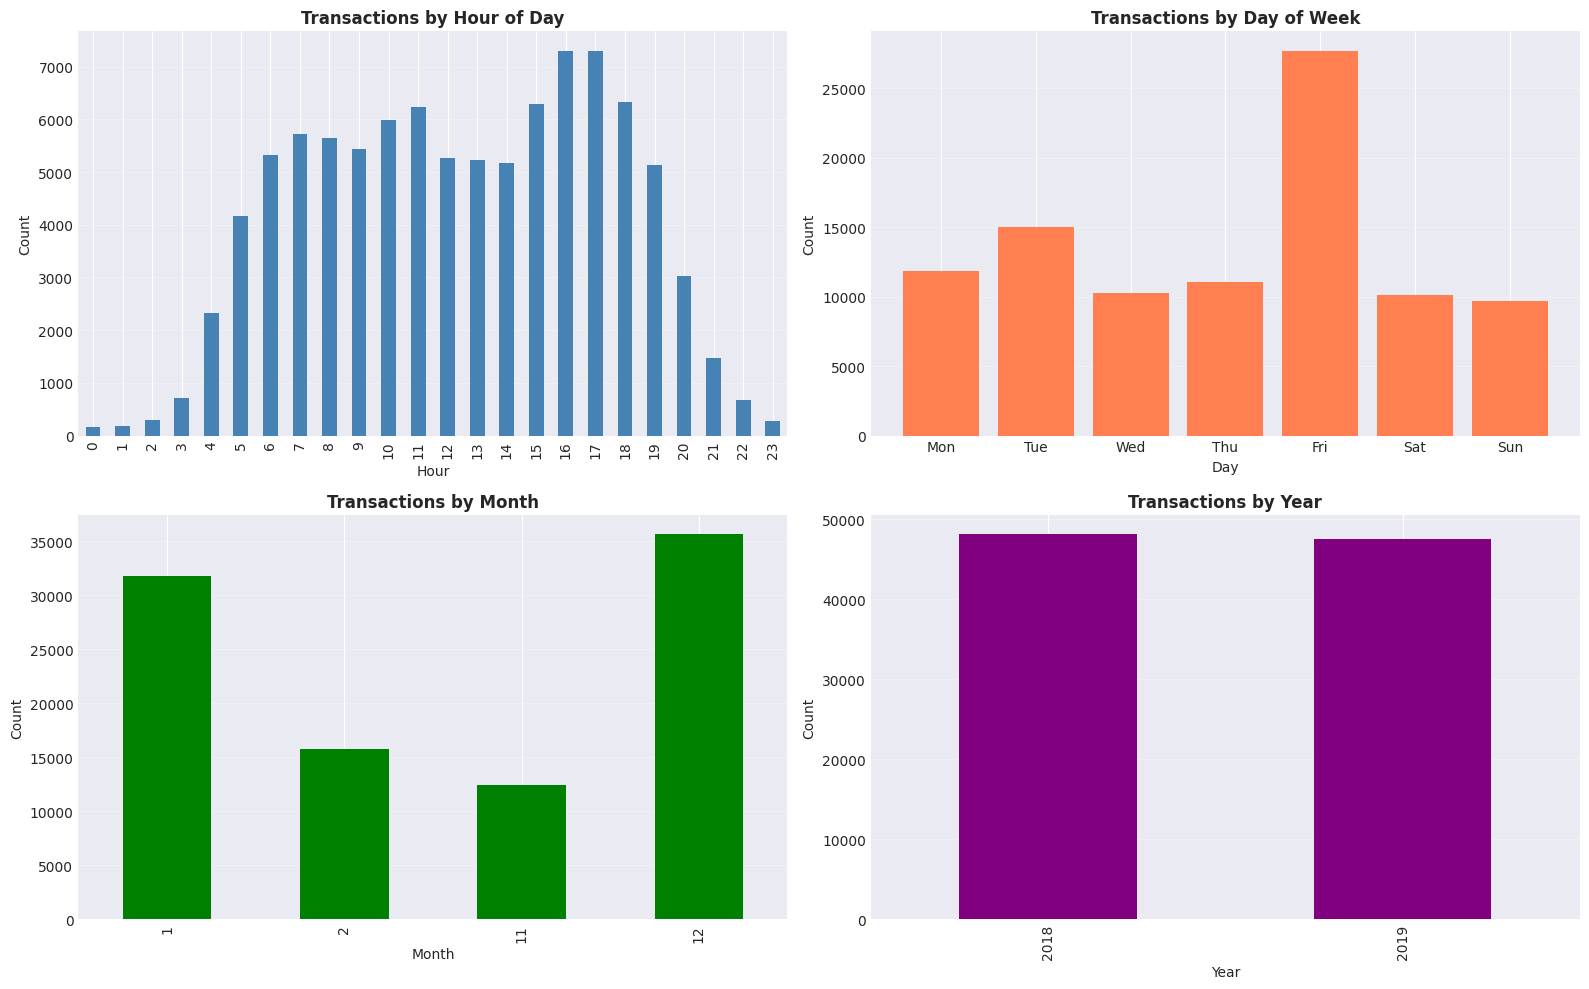

In [49]:
# Convert TransactionStartTime to datetime if exists
if 'TransactionStartTime' in df.columns:
    print("\n=== Temporal Analysis ===")
    
    # Convert to datetime
    df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], errors='coerce')
    
    # Extract temporal features
    df['transaction_hour'] = df['TransactionStartTime'].dt.hour
    df['transaction_dayofweek'] = df['TransactionStartTime'].dt.dayofweek
    df['transaction_month'] = df['TransactionStartTime'].dt.month
    df['transaction_year'] = df['TransactionStartTime'].dt.year
    
    # Time range
    print(f"Transaction Period: {df['TransactionStartTime'].min()} to {df['TransactionStartTime'].max()}")
    print(f"Duration: {(df['TransactionStartTime'].max() - df['TransactionStartTime'].min()).days} days")
    
    # Hourly distribution
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Hour of day
    df['transaction_hour'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 0], color='steelblue')
    axes[0, 0].set_title('Transactions by Hour of Day', fontweight='bold')
    axes[0, 0].set_xlabel('Hour')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Day of week
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    dow_counts = df['transaction_dayofweek'].value_counts().sort_index()
    axes[0, 1].bar(range(len(dow_counts)), dow_counts.values, color='coral')
    axes[0, 1].set_xticks(range(7))
    axes[0, 1].set_xticklabels(day_names)
    axes[0, 1].set_title('Transactions by Day of Week', fontweight='bold')
    axes[0, 1].set_xlabel('Day')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Month
    df['transaction_month'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 0], color='green')
    axes[1, 0].set_title('Transactions by Month', fontweight='bold')
    axes[1, 0].set_xlabel('Month')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Year
    df['transaction_year'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 1], color='purple')
    axes[1, 1].set_title('Transactions by Year', fontweight='bold')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## 10. Key Insights Summary

After analyzing 95,662 transactions across 16 features, we've identified critical patterns and opportunities for our credit risk modeling approach. The following insights directly inform our feature engineering strategy and RFM-based proxy target creation.

### 📊 Key Insight #1: Perfect Data Quality - No Missing Values

**Finding:**
- The dataset contains **95,662 transactions** across **16 features** with **zero missing values**
- This is exceptional for real-world transaction data and indicates strong data collection processes
- All CustomerIds, transaction amounts, and temporal data are complete

**Implication:**
- We can proceed directly to feature engineering without complex imputation strategies
- No need to create missing indicator features or drop columns due to excessive missingness
- Reduces model complexity and potential sources of bias

**Action:**
- Skip imputation steps in data processing pipeline
- Focus computational resources on feature engineering and model development
- Document this data quality strength in our Basel II model validation report

### 📊 Key Insight #2: Extreme Right-Skewed Transaction Amounts

**Finding:**
- **Amount** and **Value** features show severe right skewness (skewness > 51)
- This indicates most transactions are small, with a long tail of very large transactions
- The mean is much higher than the median, suggesting outliers pull the distribution right
- **FraudResult** also shows high skewness (22.2), indicating fraud is rare (as expected)

**Implication:**
- Linear models will struggle with these distributions without transformation
- The presence of extreme values suggests diverse customer segments (small vs large spenders)
- Large transactions might be predictive of creditworthiness but could also be outliers

**Action:**
- Apply **log transformation** to Amount and Value for modeling
- Consider creating separate features: transaction size categories (small, medium, large)
- Use robust scaling (StandardScaler) instead of MinMaxScaler to handle outliers
- Investigate whether high-value transactions correlate with low credit risk

### 📊 Key Insight #3: Near-Perfect Correlation Between Amount and Value

**Finding:**
- **Amount** and **Value** have a **0.990 correlation** (essentially the same feature)
- Value is the absolute value of Amount (Amount can be negative for credits, Value is always positive)
- This creates perfect multicollinearity if both are used in modeling

**Implication:**
- Using both features will cause problems in linear models (coefficient instability)
- One feature provides redundant information - we're essentially doubling its weight
- We must choose one or create a derived feature that captures unique information from each

**Action:**
- **For modeling:** Use only **Value** (always positive, easier to interpret)
- **Create a new feature:** `is_credit` (binary: 1 if Amount < 0, else 0) to capture transaction direction
- This gives us transaction magnitude (Value) and direction (is_credit) as separate, interpretable features
- Drop Amount from the feature set to avoid multicollinearity

### 📊 Key Insight #4: High Cardinality in Customer and Product Identifiers

**Finding:**
- **High cardinality features** include ProviderId, ProductId, CustomerId, AccountId
- These features have 50+ unique values, making one-hot encoding impractical
- ProviderId and ProductId likely have hundreds or thousands of unique values
- CustomerId and AccountId are our key aggregation identifiers for RFM analysis

**Implication:**
- One-hot encoding these features would create hundreds/thousands of sparse columns
- We need encoding strategies that handle high cardinality efficiently
- Customer and Account IDs should be used for aggregation, not as features themselves

**Action:**
- **For ProviderId and ProductId:** Use **Label Encoding** or **Target Encoding** (encoding based on target variable relationship)
- **For CustomerId and AccountId:** These are aggregation keys for creating RFM features - do not include as features directly
- Consider **frequency encoding** (replace categories with their frequency counts) as an alternative
- Use **WoE (Weight of Evidence)** transformation to create predictive bins for categorical features

### 📊 Key Insight #5: Transaction Data Suitable for RFM Analysis

**Finding:**
- Dataset contains all necessary components for RFM (Recency, Frequency, Monetary) analysis:
  - **CustomerId/AccountId:** For grouping transactions by customer
  - **TransactionStartTime:** For calculating recency (days since last transaction)
  - **Value:** For calculating monetary value (total transaction amounts)
  - **Transaction counts:** Can be aggregated to determine frequency
- Time-series nature of data allows for temporal feature engineering

**Implication:**
- We can successfully implement our proxy target variable strategy using RFM clustering
- Customers can be segmented into high-risk vs low-risk based on engagement patterns
- Temporal features (hour, day, month) can enrich our feature set beyond basic RFM

**Action:**
- **Calculate RFM metrics per customer:**
  - Recency: Days between last transaction and reference date
  - Frequency: Number of transactions per customer
  - Monetary: Total/average transaction value per customer
- **Apply K-Means clustering** (k=3) on scaled RFM metrics
- **Assign risk labels:** Identify least engaged cluster as high-risk (1), others as low-risk (0)
- **Create temporal features:** Extract hour, day of week, month, year from TransactionStartTime
- **Merge risk labels** back to transaction-level data for modeling

---

## Summary and Next Steps

### EDA Conclusions

**Data Quality:** ✅ Excellent
- Zero missing values across all features
- No duplicate TransactionIds
- Clean temporal data for time-series analysis

**Key Challenges Identified:**
1. Severe right-skewness in transaction amounts requires log transformation
2. Multicollinearity between Amount and Value needs resolution
3. High cardinality categorical features require sophisticated encoding

**Opportunities Discovered:**
1. Perfect dataset for RFM analysis and proxy target creation
2. Rich temporal data for extracting time-based features
3. Clear customer segmentation potential

---

**EDA Complete** ✅ | **Ready for Feature Engineering** ➡️